# Capstone Project 1: Track genre classification based on its audio features

## Overview

This capstone project will focus on genre classification of tracks based on audio features measured and evaluated by Spotify. By classifying musical tracks by its genre, one would be able to create a model that can figure out, based on its audio features, if a track belongs to a certain genre. This might be relevant to music companies trying to classify new music they are producing or to individuals who are trying to find songs categorized in a similar genre to their musical tastes. 


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import requests
import json
import helper
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle

from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn import svm, datasets
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

warnings.filterwarnings("ignore")
sns.set()

Link for token generation:
https://developer.spotify.com/console/get-current-user-playlists/?limit=&offset=

In [13]:
# Token needs to be generated everytime; will expire after a while...
token = "BQDS1zS_ygEgbnDMYdjSZjKC3x3lGWboojoHOW-WR0JrgQDR-iDjhFXfd_sc5QjH3L4dVQJNWCulv6h2jirdlzcddFXkq68Xbly458nO0y55UOU10siYZxLTyy9yeizh50T69f99wCoTVPNDpFgNPWW3kHYtoN3GrWmE-6uFAnrS25QfLEO6NY9uSyUKT5HhFEcVtlevd0nUTiZBaYckqjGCuIdJfKnQ9nOazMfcG_xbdSeyFrdt6C3-mNJqBpS9AEk_8R0x4-dDXsqcQqI"

## Data Wrangling

This section is primarily used for wrangling the data that can be procured through the Spotify API. Because the coding can get complex, I've decided to create a helper.py that contains python methods that are used to wrangle the data. Please see the file for the code and more information on each method to help wrangle the Spotify data.

NOTE: The final data wrangled dataset has been pickled in 'tracks_genre.pkl' for future use so we don't have to go through the steps again.

In [2]:
# load pickled data file - load this instead of going through the steps
df = pd.read_pickle("tracks_genre.pkl")

In [ ]:
# helper.get_playlist_list(token) # get the names of the playlists to use

In order to get the tracks, a playlist of each genre was made to house each of the tracks. One advantage of this is that each track can be easily labeled by its playlist name, which I named after each genre. This is useful for any classification techniques to be employed later in this project. Each track was added using Spotify's recommender system and was screened for correctness.

In [ ]:
# playlist ids of the playlists containing the songs of each genre for classification
classical_id = '1eE7grg1fspxFTzcaqnr7H'
country_id = '6s5PLDbBCiJB2H3ksvd7eW' 
rock_id = '5xOh7ZScLfijnSuZC7jKbY' 
hiphop_id = '1FbnYjA107nOCwSMxEClWy'
pop_id = '68JKNex2kXZDXrZKYwqi4u' 


In [ ]:
classical_df = helper.get_df_from_playlist(classical_id, token).reset_index().drop_duplicates('id')

In [ ]:
country_df = helper.get_df_from_playlist(country_id, token).drop_duplicates('id')

In [ ]:
rock_df = helper.get_df_from_playlist(rock_id, token).drop_duplicates('id')

In [ ]:
hiphop_df = helper.get_df_from_playlist(hiphop_id, token).drop_duplicates('id')

In [ ]:
pop_df = helper.get_df_from_playlist(pop_id, token).drop_duplicates('id')

In [ ]:
# Confirm that each df has the same amount of tracks.

print('The classical dataframe has', classical_df.name.count(), 'tracks')
print('The country dataframe has', country_df.name.count(), 'tracks')
print('The rock dataframe has', rock_df.name.count(), 'tracks')
print('The hiphop dataframe has', hiphop_df.name.count(), 'tracks')
print('The pop dataframe has', pop_df.name.count(), 'tracks')

In [ ]:
# combine the playlists into one df
dfs = [classical_df.drop_duplicates('id'), 
       country_df.drop_duplicates('id'), 
       rock_df.drop_duplicates('id'), 
       hiphop_df.drop_duplicates('id'), 
       pop_df.drop_duplicates('id')]

df = pd.concat(dfs, sort=True).reset_index().drop_duplicates('id')
df.playlist_name =  df.playlist_name.astype('category')
# convert categories into numbers in order to plot
df['label_num'] = df.playlist_name.cat.codes

In [ ]:
# pickle for later use
df.to_pickle('tracks_genre.pkl')

## Exploratory Data Analysis

In order to successfully classify the tracks based on their genre, it is necessary to figure out if there are differences among the genres with respect to the Spotify track features. If there are differences, then that means that it would be possible to create a model based on the genres to classify new tracks.

Some questions that I will be asking are:

* Are there features or parameters that can differentiate the genres and can these be seen visually?
* Are there similarities in the different features?


### Look at the different features among the different genres

This section takes a look at comparing different playlists with each other in regards to their features. The features chosen are ones that have values and easily comparable in a swarm plot and its complementary violin plot; both look at the distribution of the values. These features are: acousticness, danceability, energy, instrumentalness, liveness, loudness, tempo, speechiness and valence. These features were measured/evaluated by Spotify.

#### Definitions of the features (https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

acousticness:	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

danceability:	Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

energy:	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

instrumentalness:  Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

liveness:	Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

loudness:	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

speechiness: 	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

tempo: 	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

valence:	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 


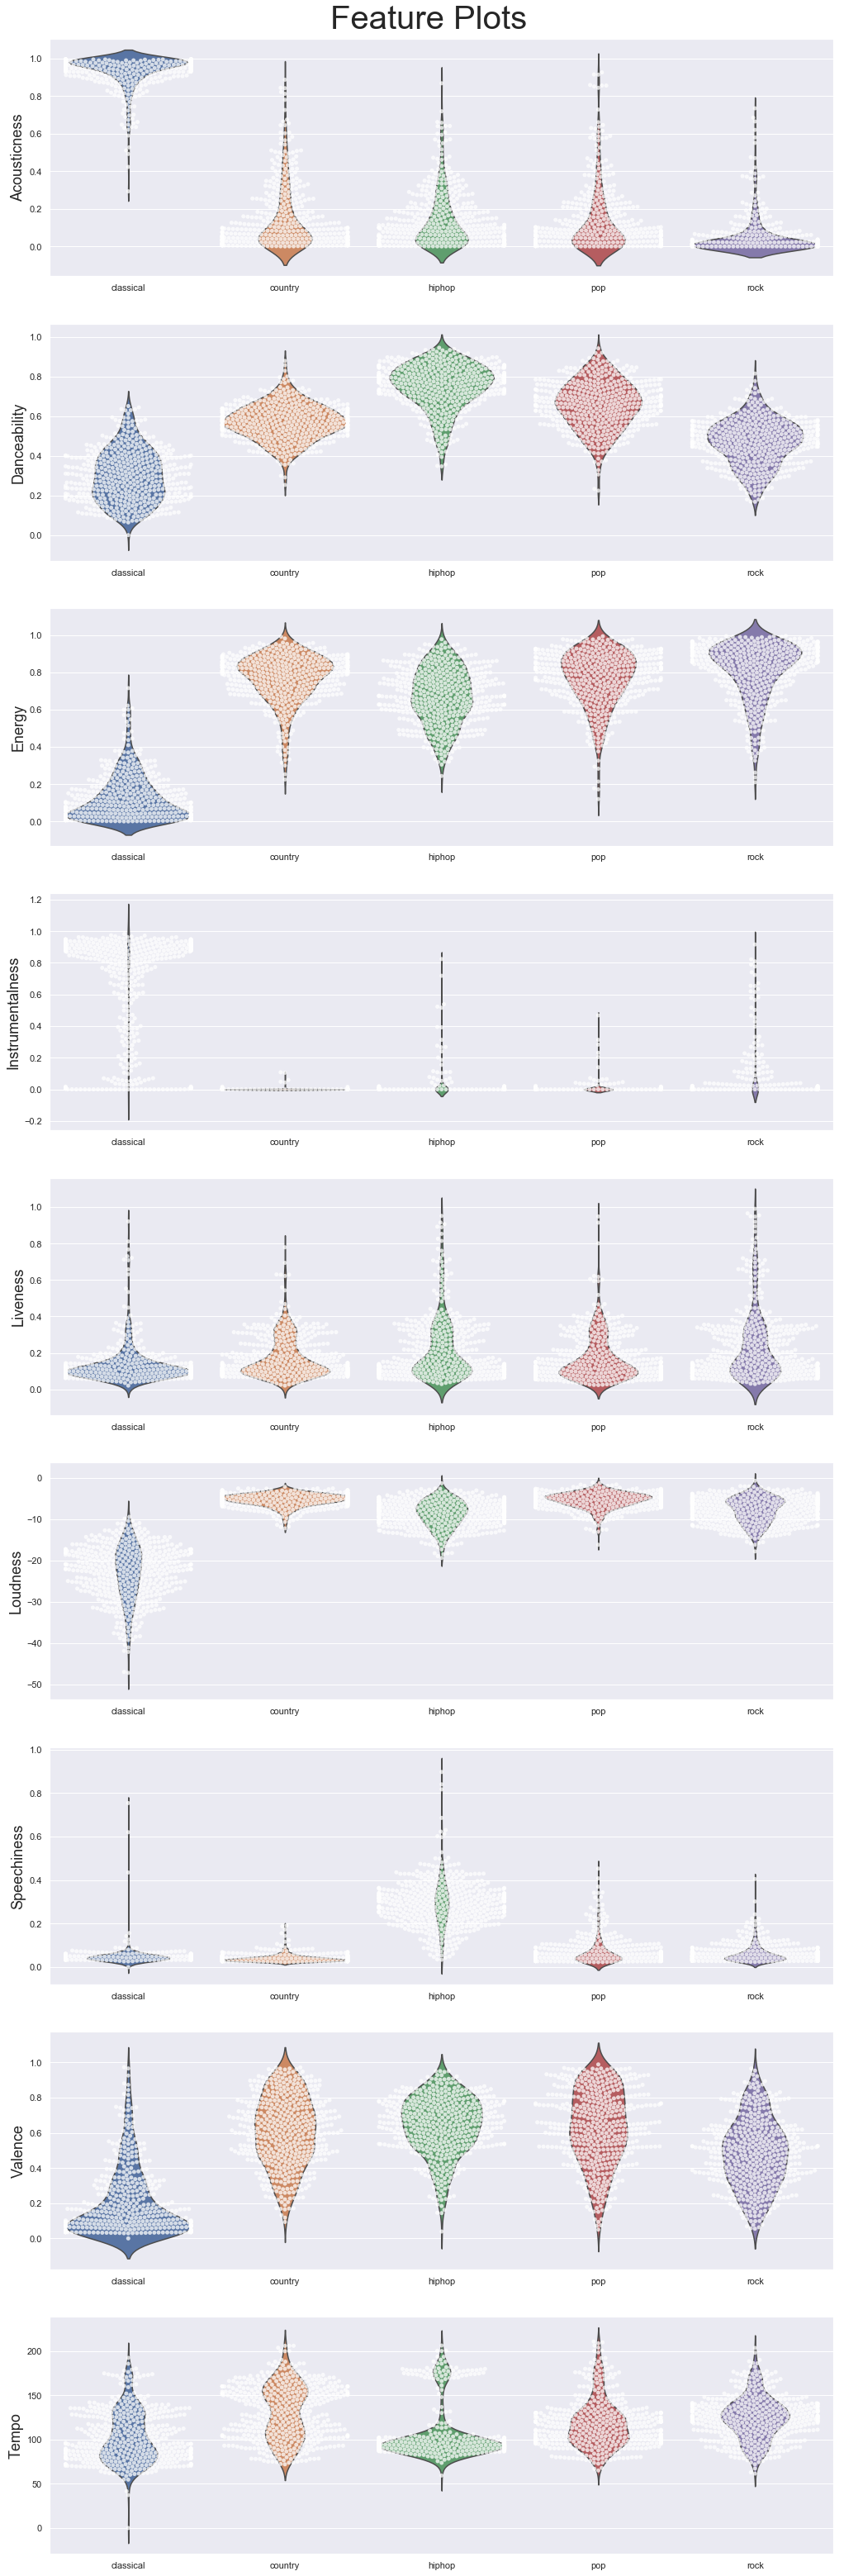

In [3]:
# Create feature plots
title = 'Feature Plots'
fig = plt.figure(figsize=(17,56))        
fig.suptitle(title, fontsize=40, y=.89)
    
k = 1
features_orig = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
                'loudness', 'speechiness', 'valence', 'tempo']

for feature in features_orig:
            
    plt.subplot(9,1,k)
    sns.violinplot(x="playlist_name", y=feature, data=df, inner=None)
    sns.swarmplot(x="playlist_name", y=feature, data=df,
              color="white", edgecolor="gray", alpha=0.75)
    plt.ylabel(feature.title(), fontsize=18)
    plt.xlabel('')
            
    k = k+1
    
plt.show()

Classical: Tends to be acoustic and instrumental. Tends to lack energy, danceability and valence. Greater distribution of loudness compared to the other genres.

Country: Tempo seems to be bimodal.

Hiphop: More speechiness compared to the rest of the genres. Most danceable than all of the other genres. Like country, tempo seems to have a bimodal population.

Pop: Besides tempo, the pop and country genres seem to have similar distributions among the features.

Rock: Seems to be the least acoustic genre.



### Inferential Statistics

As we can from above, some of the different features have the same distributions as other features. In order to quantitatively measure this, we can use a correlation matrix between the different features to see their correlations with one another. The following would tell us how strong a relationship is between the different features depending on their correlation value:

* –1 A perfect downhill (negative) linear relationship
* –0.70 A strong downhill (negative) linear relationship
* –0.50 A moderate downhill (negative) relationship
* –0.30 A weak downhill (negative) linear relationship
* 0. No linear relationship
* +0.30 A weak uphill (positive) linear relationship
* +0.50 A moderate uphill (positive) relationship
* +0.70 A strong uphill (positive) linear relationship
* 1 A perfect uphill (positive) linear relationship

Basically, the closer the the correlation value is to one, the stronger the relationship between the two features are.

In [4]:
# correlation matrix

corr_matrix = df[features_orig].corr()
corr_matrix.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
acousticness,1,-0.55284,-0.868843,0.781645,-0.184027,-0.805688,-0.182699,-0.567468,-0.219939
danceability,-0.55284,1,0.472092,-0.562811,0.0471952,0.526474,0.40867,0.669614,-0.0746512
energy,-0.868843,0.472092,1,-0.729134,0.233415,0.885641,0.116896,0.623373,0.273053
instrumentalness,0.781645,-0.562811,-0.729134,1,-0.151355,-0.759115,-0.21284,-0.550656,-0.19793
liveness,-0.184027,0.0471952,0.233415,-0.151355,1,0.167566,0.144169,0.128352,0.0515195
loudness,-0.805688,0.526474,0.885641,-0.759115,0.167566,1,0.0933862,0.582664,0.252483
speechiness,-0.182699,0.40867,0.116896,-0.21284,0.144169,0.0933862,1,0.231568,-0.0676006
valence,-0.567468,0.669614,0.623373,-0.550656,0.128352,0.582664,0.231568,1,0.168341
tempo,-0.219939,-0.0746512,0.273053,-0.19793,0.0515195,0.252483,-0.0676006,0.168341,1


According to the matrix above, acousticness, energy, instrumentalness, and loudness have strong linear relationships with each other as they all have correlations above .7 (positive or negative) from each other. Since 

### PCA

Another useful feature of PCA is that the principal components are ordered by the amount of variance of each component meaning that the first couple of principal components will contain a bulk of the variance. This can lead to dimension reduction in modeling as you want to explain as much variance as possible with as little features.

In [5]:
X = df[features_orig]
y = df['playlist_name']

scaler=StandardScaler()
pca=PCA()

pipeline=make_pipeline(scaler, pca)

pca_features=pipeline.fit_transform(X)

# get the samples for the PCA components
xs=pca_features[:,0]
ys=pca_features[:,1]

df_pca = pd.DataFrame({'track':df['name'],
                       'artist':df['artist'],
                       'id':df['id'], 
                       'label':df['playlist_name'], 
                       'x':xs,'y':ys})

df_pca.head()

,track,artist,id,label,x,y
0,"Liebestraume, S541/R211 : No. 3: Nocturne in A...","[Franz Liszt, Jenő Jandó]",6GzMz3s0K1YKwRVI36CgRx,classical,4.952605,1.037234
1,"Sonata No. 14 ""Moonlight"" in C-Sharp Minor"", O...","[Ludwig van Beethoven, Paul Lewis]",3DNRdudZ2SstnDCVKFdXxG,classical,5.215453,-1.053256
2,"Requiem, K. 626: Lacrimosa","[Wolfgang Amadeus Mozart, Academy of Ancient M...",3oHSL6pt9LpNrQZuQGu9wL,classical,4.647147,-0.857539
3,"Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10,...","[Pyotr Ilyich Tchaikovsky, André Previn, Londo...",2xizRhme7pYeITbH1NLLGt,classical,4.534470,-0.249153
4,"Serenade for Strings in E Major, Op. 22, B. 52...","[Antonín Dvořák, Prague Chamber Orchestra, Pet...",3sAYxq1986j3ydqLv6jwUJ,classical,5.037952,0.927779


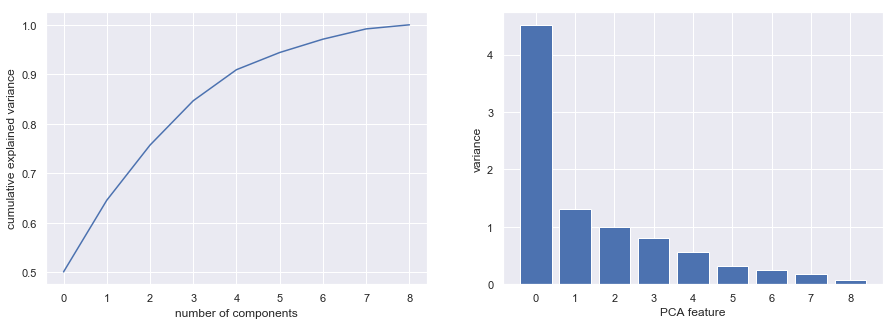

In [6]:
fig = plt.figure(figsize=(15,5)) 

plt.subplot(1,2,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Plot the explained variances
plt.subplot(1,2,2)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

The explained variance reaches 90 percent with only 4 PCA components.

In [7]:
pca_components=pd.DataFrame(pipeline.named_steps['pca'].components_, columns=features_orig)
pca_components

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,0.425970,-0.337313,-0.427913,0.406291,-0.113744,-0.422367,-0.137819,-0.362286,-0.122520
1,0.097023,0.435944,-0.191635,0.034130,0.000214,-0.174251,0.614263,0.138209,-0.579539
2,0.025921,-0.195495,0.023555,0.058718,0.927537,-0.062078,0.258613,-0.107427,0.120449
3,0.116687,0.041331,-0.136747,0.061604,-0.241934,-0.150410,0.547689,0.117580,0.753152
4,-0.264197,-0.313809,0.124843,-0.281961,-0.212722,0.147460,0.405175,-0.700725,-0.120246
5,-0.066503,-0.452960,0.435555,0.601132,-0.140987,0.169758,0.246776,0.314872,-0.174926
6,-0.150789,0.566440,0.095808,0.597867,0.047810,0.231929,-0.074382,-0.454344,0.147467
7,-0.728806,-0.001742,0.012600,0.103511,-0.007339,-0.670523,-0.072937,0.052462,0.015415
8,0.408325,0.178157,0.739107,-0.132283,-0.027177,-0.459142,-0.030414,-0.157929,0.018325


The above table shows the 'weights' of each feature on each principal component. The first component seems to favor acousticness and instrumentalness which are traits of the classsical genre. The second component seems to favor speechiness and danceability which are traits of the hiphop genre.

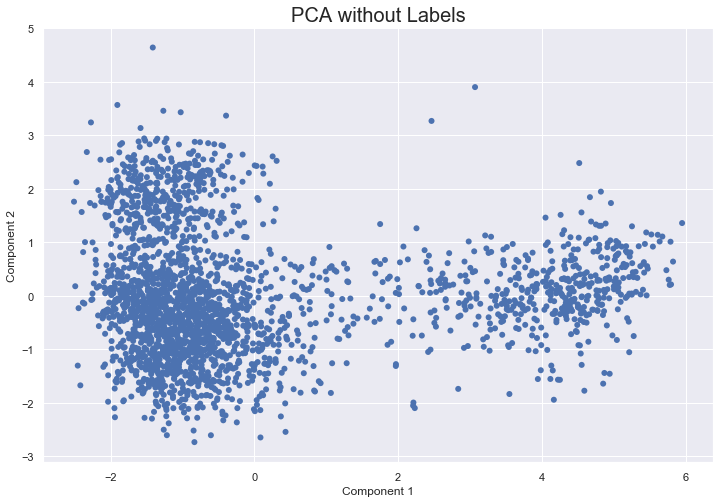

In [8]:
# plot a scatterplot without labels
fig = plt.figure(figsize=(12,8)) 
plt.scatter(pca_features[:, 0], pca_features[:, 1],
            edgecolor='none')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA without Labels', fontsize=20)
plt.show()

Without labeling, a PCA plot may indicate that there are two or three distinct blob populations among all the data.

In [9]:
# convert categories into numbers in order to plot
df_pca['label_num'] = df_pca.label.cat.codes

In [10]:
c_map=ListedColormap(colors=['darkblue','darkorange','darkgreen','darkred','purple'])

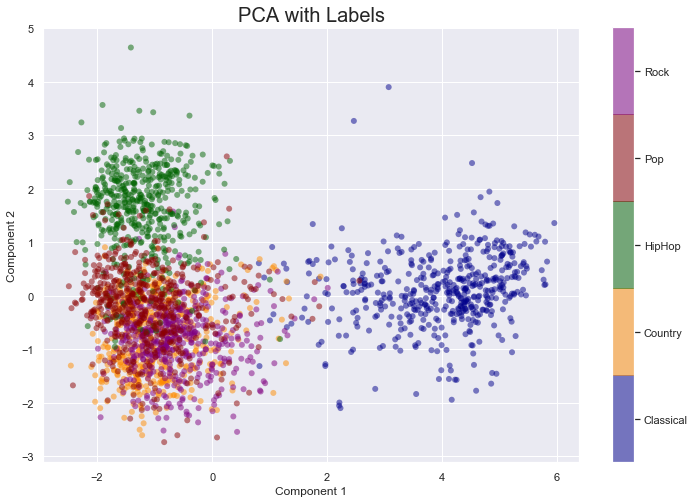

In [11]:
# plot scatterplot of pca with labels
fig = plt.figure(figsize=(12,8))  
plt.scatter(pca_features[:, 0], pca_features[:, 1],
            c=df_pca.label_num, edgecolor='none', alpha=0.5,
            cmap=c_map)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
cbar=plt.colorbar(ticks=[0.4,1.2,2.0,2.8,3.6])
cbar.ax.set_yticklabels(['Classical','Country','HipHop','Pop','Rock'])
plt.title('PCA with Labels', fontsize=20)
plt.show()

Classical seems to be very different from the other genres based on the first principal component, whereas hiphop seems to be different from the other genres based on the second principal component. The aforementioned observations are in line with the anlysis of the PCA 'weights' of the features above. Country, pop and rock seem to have populations overlapping each other which may mean that it would be difficult to discern these genres based on their PCA values.

### Conclusions

The classical and hiphop genres look to be the easiest to discern based on a couple of features where they are both clearly separate from the genres. This can be seen in instrumentalness and acousticness for classical, and speechiness for hiphop. A classifier might have a more difficult time with country, pop, and rock as there is only minor differences in the feature values. These differences and similarities is further exposed in the PCA plot above. 


## In-depth Analysis and Modeling

After exploring the data, we have some intuition on if it would be possible to classify the tracks by genres. From the previous analysis, it can be concluded that there is enough variance between the groups that a classifier may be successful at classifying the data. Therefore, we can continue on to create a model. For the model to be successful, it would need to be able to classify the tracks by genre somewhat accurately. 

As this is a classic classifier problem, a logistic regression model would probably be best because the feature values are continuous and a regression model does well with that type of data. Other classifiers like k-nearest neighbors or SVM would probably not work as well because as we’ve seen earlier the genres of pop, rock and country have similar feature values close to each other. This is also further evidenced in the PCA plot. Therefore, it would be difficult for KNN or SVM to create boundaries for these genres without overfitting like crazy. Another plausible candidate for a classifier is Naive Bayes, but for now, we will be using a logistic regression model from the sklearn library. 


#### Logistic Regression

In [12]:
X = df[features_orig]
y = df['playlist_name']

# preprocessing steps
scaler = StandardScaler()
pca = PCA()

# model selection
model = LogisticRegression(solver='lbfgs')

# create pipeline
pipe = make_pipeline(scaler, pca, model)

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# tuning hyperparameters
Cs = [0.01, 0.1, 1, 10, 100]
n_components = [2, 4, 6, 8]

pipe_cv = GridSearchCV(pipe, dict(pca__n_components=n_components, logisticregression__C=Cs), cv=5)

pipe_cv.fit(X_train, y_train)

# pickle the model for future use
filename = 'lr_finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

y_pred = pipe_cv.predict(X_test)

# Compute and print metrics
print('The optimal parameters from training:', pipe_cv.best_params_)
print('The best score on the training data:', pipe_cv.best_score_)

print("\nAccuracy on the test set: {}\n".format(pipe_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))


The optimal parameters from training: {'logisticregression__C': 10, 'pca__n_components': 8}
The best score on the training data: 0.7869727709556861

Accuracy on the test set: 0.816

              precision    recall  f1-score   support

   classical       0.98      0.99      0.99       125
     country       0.68      0.72      0.70       125
      hiphop       0.93      0.96      0.94       125
         pop       0.69      0.54      0.61       125
        rock       0.77      0.86      0.82       125

   micro avg       0.82      0.82      0.82       625
   macro avg       0.81      0.82      0.81       625
weighted avg       0.81      0.82      0.81       625



As we can see, the best parameters to use is a C value of 10 and all 8 PCA components. The best score from the grid search cross validation turns out to be ~79% accurate. With using this model and hyperparameters, we get a final testing accuracy score of 81.6% which surprisingly does better than the training set. By looking deeper into the scoring, we can see the precision and recall for each of the genres. This is very close to what we can expect from what the EDA showed us in the previous section. The two genres that did the best in the classification is classical and hiphop with accuracies higher than 90% whereas the other genres did not do so well. Recall that the classical and hiphop genres had populations that were separate while the other genres’ populations were not so easily separable. 

In [13]:
# create confusion matrix
row_labels = ['classical', 'country', 'hiphop', 'pop', 'rock', 'total_pred']
col_labels = ['classical_pred', 'country_pred', 'hiphop_pred', 'pop_pred', 'rock_pred', 'total']

mat=confusion_matrix(y_test, y_pred)
mat=np.vstack([mat,np.sum(mat,axis=0)])
h=np.reshape(np.sum(mat,axis=1),(-1,1))
mat=np.hstack([mat,h])

pd.DataFrame(mat, index=row_labels, columns=col_labels)

,classical_pred,country_pred,hiphop_pred,pop_pred,rock_pred,total
classical,124,1,0,0,0,125
country,0,90,1,20,14,125
hiphop,0,0,120,5,0,125
pop,1,31,7,68,18,125
rock,1,10,1,5,108,125
total_pred,126,132,129,98,140,625


This table shows the actual count versus the predicted count of each genre for the testing. Rock has the most number of predictions, whereas pop has the least.

In [14]:
# see which songs were incorrectly predicted to get intuition
df['label_pred'] = pipe_cv.predict(X)
tmp = df[['name','artist','album','playlist_name','label_pred']]

inc_classical = tmp[(tmp.playlist_name=='classical') & (tmp.label_pred!='classical')]
inc_country = tmp[(tmp.playlist_name=='country') & (tmp.label_pred!='country')]
inc_hiphop = tmp[(tmp.playlist_name=='hiphop') & (tmp.label_pred!='hiphop')]
inc_pop = tmp[(tmp.playlist_name=='pop') & (tmp.label_pred!='pop')]
inc_rock = tmp[(tmp.playlist_name=='rock') & (tmp.label_pred!='rock')]

In [15]:
inc_classical.head()

,name,artist,album,playlist_name,label_pred
420,Aeolian Harp,"[Henry Cowell, Wilhem Latchoumia]",Prokofiev: Cinderella,classical,hiphop
497,Ein Paar tränen werd ich weinen um dich,[Zarah Leander],Der Wind hat mir ein Lied erzählt,classical,country


In [16]:
inc_country.head()

,name,artist,album,playlist_name,label_pred
502,House Party,[Sam Hunt],Montevallo,country,pop
503,Hurricane,[Luke Combs],This One's for You,country,rock
508,Knee Deep (feat. Jimmy Buffett),"[Zac Brown Band, Jimmy Buffett]",You Get What You Give (Deluxe),country,pop
517,I Love This Bar,[Toby Keith],Shock 'N Y'all,country,rock
519,Country Girl (Shake It For Me),[Luke Bryan],Tailgates & Tanlines,country,pop


In [17]:
inc_hiphop.head()

,name,artist,album,playlist_name,label_pred
1502,Washington Square,"[Chinese Man, Bionic Man Sound]",Groove Sessions,hiphop,pop
1505,Erase Me - Main,"[Kid Cudi, Kanye West]",Man On The Moon II: The Legend Of Mr. Rager,hiphop,pop
1506,Ghetto Gospel,[2Pac],Loyal To The Game,hiphop,pop
1523,The Guillotine,[The Coup],Sorry To Bother You,hiphop,pop
1524,It Was A Good Day,[Ice Cube],The Predator,hiphop,pop


In [18]:
inc_pop.head()

,name,artist,album,playlist_name,label_pred
2003,Larger Than Life,[Backstreet Boys],Millennium,pop,country
2006,PILLOWTALK,[ZAYN],Mind Of Mine (Deluxe Edition),pop,country
2009,I'm Like A Bird,[Nelly Furtado],"Whoa, Nelly!",pop,country
2010,Uptown Girl - Radio Edit,[Westlife],Coast To Coast,pop,country
2012,Dirrty (feat. Redman),"[Christina Aguilera, Redman]",Stripped,pop,hiphop


In [19]:
inc_rock.head()

,name,artist,album,playlist_name,label_pred
999,Back In Black,[AC/DC],Back In Black,rock,country
1003,Stairway to Heaven - Remastered,[Led Zeppelin],Led Zeppelin IV (Deluxe Edition),rock,country
1004,Dream On,[Aerosmith],Aerosmith,rock,country
1005,Californication,[Red Hot Chili Peppers],Californication (Deluxe Version),rock,country
1010,Highway to Hell,[AC/DC],Highway to Hell,rock,pop


Talk about why they may have been wrong...

In [20]:
# Create ROC curves
# original code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
y = df['label_num']

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# preprocessing steps
scaler = StandardScaler()
pca = PCA()

# model selection
model = LogisticRegression(solver='lbfgs', C=10)

# create pipeline
pipe = make_pipeline(scaler, pca, model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(pipe)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

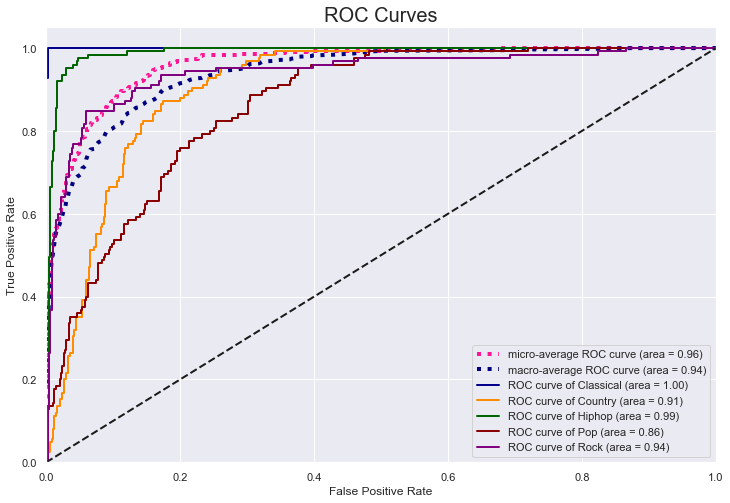

In [21]:
# Compute macro-average ROC curve and ROC area
# original code: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
class_labels=['Classical','Country','Hiphop','Pop','Rock']

# Plot all ROC curves
lw=2
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()

Observations:
Classical and hiphop are the two genres that have highest accuracy.

### Naive Bayes Classifier

In [42]:
X = df[features_orig]
X_cleaned = df[features_cleaned]
y = df['playlist_name']

# preprocessing steps
scaler = StandardScaler()
pca = PCA()

# model selection
model = GaussianNB()

# create pipeline
pipe = make_pipeline(scaler, pca, model)

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# tuning hyperparameters
n_components = [2, 4, 6, 8]

pipe_cv = GridSearchCV(pipe, dict(pca__n_components=n_components), cv=5)

pipe_cv.fit(X_train, y_train)

y_pred = pipe_cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}\n".format(pipe_cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print(pipe_cv.best_params_)

Accuracy: 0.8064

              precision    recall  f1-score   support

   classical       0.98      1.00      0.99       125
     country       0.65      0.64      0.65       125
      hiphop       0.93      0.94      0.94       125
         pop       0.64      0.66      0.65       125
        rock       0.84      0.79      0.81       125

   micro avg       0.81      0.81      0.81       625
   macro avg       0.81      0.81      0.81       625
weighted avg       0.81      0.81      0.81       625

{'pca__n_components': 8}


In [43]:
# create confusion matrix
mat=confusion_matrix(y_test, y_pred)
mat=np.vstack([mat,np.sum(mat,axis=0)])
h=np.reshape(np.sum(mat,axis=1),(-1,1))
mat=np.hstack([mat,h])

pd.DataFrame(mat, index=row_labels, columns=col_labels)

,classical_pred,country_pred,hiphop_pred,pop_pred,rock_pred,total
classical,125,0,0,0,0,125
country,2,80,0,32,11,125
hiphop,0,0,118,6,1,125
pop,1,28,7,82,7,125
rock,0,15,2,9,99,125
total_pred,128,123,127,129,118,625


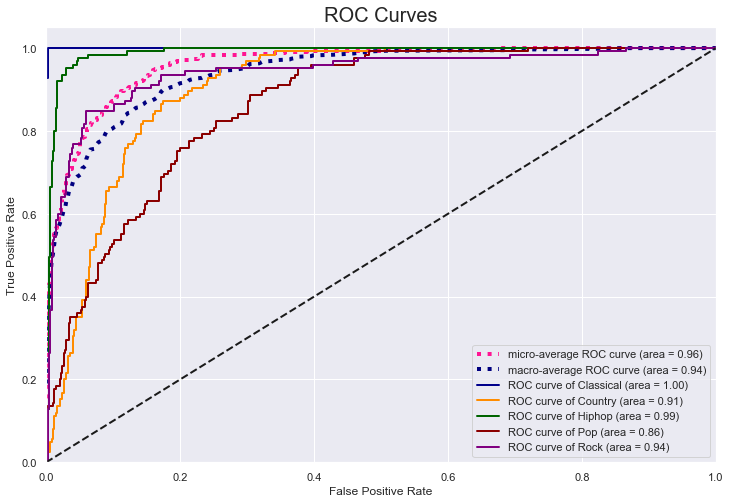

In [44]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
class_labels=['Classical','Country','Hiphop','Pop','Rock']

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=20)
plt.legend(loc="lower right")
plt.show()

## Conclusions

### Discussion
* Successfulness of the modeling.

### Future Work

* Employ deep learning like neural networks or other machine learning techniques.
* Integrate more musical genres, e.g. EDM, jazz, funk, etc.
* Get more data.
* Research and utilize other types of features like popularity or explicitness. 
* See how different eras affect the features of each genre (e.g. 80s rock versus 00s rock).